In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from   sklearn.preprocessing import LabelEncoder, StandardScaler
from   sklearn.model_selection import train_test_split
import datetime
import os
import seaborn as sns

In [2]:
def box_plot(df_, x_, y_, legend = True):
    pal = sns.color_palette()
    plt.figure(figsize=(15,6))
    ax = sns.boxplot(x = x_,
                     y = y_,
                     data = df_,
                     palette = pal)

    if(legend):
        ax.legend(df[x_].unique(),
                  labelcolor = pal,
                  loc = 'upper right',
                   fontsize=12)
    #plt.setp(ax.artists, alpha=0.9)
    plt.xticks(rotation = 60)

In [3]:
# dataset source
# https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho

df = pd.read_csv('Car details v3.csv') # Похоже, что цены указаны в рублях
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
df.describe() # видно, что значение максимальной цены сильно отличается от квантиля 75, значит нужно будет обработать выборсы

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [5]:
df = df[df['selling_price'] < 800000] # Регрессионная модель не устойчива к выбросам, отбросим все автомобили с ценой более 800000
print(df.shape)

(6741, 13)


In [6]:
df.info() # Видно, что датасет содержит пропущенные значения, и некоторые признаки нужно будет привести к другом типу данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6741 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6741 non-null   object 
 1   year           6741 non-null   int64  
 2   selling_price  6741 non-null   int64  
 3   km_driven      6741 non-null   int64  
 4   fuel           6741 non-null   object 
 5   seller_type    6741 non-null   object 
 6   transmission   6741 non-null   object 
 7   owner          6741 non-null   object 
 8   mileage        6523 non-null   object 
 9   engine         6523 non-null   object 
 10  max_power      6529 non-null   object 
 11  torque         6522 non-null   object 
 12  seats          6523 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 737.3+ KB


In [7]:
# Пропущенных значений не так много, поэтому можно убрать строки с пропущенными значениями
 
isna_series = df.isna().sum() 
print('Before: ' + str(df.shape))
for i in range(0, isna_series.size):
    if(isna_series[i] > 0):
        print(isna_series.index[i], '  ', isna_series[i])

for i in range(0, isna_series.size):
    if(isna_series[i] > 0):
        df = df[df[isna_series.index[i]].notna()]
    isna_series = df.isna().sum() 
    
print('After: ' + str(df.shape))
for i in range(0, isna_series.size):
    if(isna_series[i] > 0):
        print(isna_series.index[i], '  ', isna_series[i])

Before: (6741, 13)
mileage    218
engine    218
max_power    212
torque    219
seats    218
After: (6522, 13)


In [8]:
# Убираем полное название машины, оставляем только марку
# При этом сохраним полное название для дальнейшего анализа

car_names = np.array(df['name'])
for i in range(0, car_names.shape[0]):
    name = car_names[i].split(' ')[0]
    car_names[i] = name

df['mark'] = car_names

In [9]:
# Заменяем год выпуска возрастом машины

now = datetime.datetime.now()
df['Age'] = now.year - df['year']
df.drop('year',axis=1,inplace = True)

In [10]:
# Большая часть машин использует солярку или бензин, для них расход топлива в киллометрах на литр, для газа в киллометрах на кг
# Автомобилей с газовызм топливом значительно меньше, их можно не рассматривать
print(df['fuel'].value_counts())

Petrol    3273
Diesel    3162
CNG         52
LPG         35
Name: fuel, dtype: int64


In [11]:
# Далее будем рассматривать только автомобили с жидким топливом
kmkg = 0
kmpl = 0
_indexes = []
df.index = range(0, len(df.mileage))

for i in range(0, len(df.mileage)):
    str_ = str(df.mileage[i])
    if str_.endswith("km/kg"):
        kmkg+=1
        _indexes.append(i)
        
    elif str_.endswith("kmpl"):
    #else:
        kmpl+=1
        df.loc[i, 'mileage'] = str_.split(' ')[0]


print(kmkg)
print(kmpl)

df  = df.drop(df.index[_indexes])
df.index = range(0, len(df.mileage))
df['mileage'] = df['mileage'].astype(float)

# CNG in kg/M³ is 0.656 kg/M³ 
# 800 kg/m3
# 1.898 kg/m3
# летнее ДТ – 860 кг/M³, зимнее ДТ – 840 кг/M³ 

87
6435


In [12]:
# уберём единицу измерения CC для всех двигателей приведем тип из строки в численный
for i in range(0, len(df.engine)):
    df.loc[i,'engine'] = str(df.engine[i]).split(' ')[0]

df['engine'] = df['engine'].astype(int)

# уберём единицу измерения bhp для всех мощностей приведем тип из строки в численный

for i in range(0, len(df.max_power)):
    df.loc[i, 'max_power'] = str(df.max_power[i]).split(' ')[0]
    
df['max_power'] = df['max_power'].astype(float)

In [13]:
# Большая часть строк содержит информацию о крутящем моменте в rpm, возьмем только те строки в которых есть rpm,
# диапазоны заменим средним
# предстоит отчистить много строк, на самом деле это самая сложная часть предобработки

_indexes = []
for i in range(0, len(df.torque)):
    string = df['torque'][i]
    string = string.lower()
    if('rpm' in string):
        string = string.replace('(kgm@ rpm)', '') # попробуем учесть максимальное количество вариантов
        string = string.replace('Nm at ', '') # можно улучшить или найти более оптимальный способ
        string = string.replace(' rpm', '') 
        string = string.replace('rpm', '')
        string = string.replace(' RPM', '')
        string = string.replace('RPM', '')
        string = string.replace('kgm@', '')
        string = string.replace('kgm at', '')
        string = string.replace(' KGM at', '')
        string = string.replace('Nm', '')
        string = string.replace('24 KGM at ', '')
        string = string.replace('Nm', '')
        string = string.replace('Nm at', '')
        string = string.replace('(', '')
        string = string.replace(')', '')
        string = string.replace(',', '')
        string = string.replace('/', '')
               
        string = string.split(' ')[-1]
        
        df.loc[i, 'torque'] = string
        
        if not string:
            _indexes.append(i)
    else:
        _indexes.append(i)

df  = df.drop(df.index[_indexes])
df.index = range(0, len(df.torque))

In [14]:
for i in range(0, len(df.torque)):
    string = df['torque'][i]
    if('+-' in string):
        val = float(string.split('+-')[0])       
        string = str(val)
    elif('-' in string):
        first_val = float(string.split('-')[0])
        second_val = float(string.split('-')[1])
        val = (second_val - first_val) / 2
        string = str(val)
    elif('~' in string):
        first_val = float(string.split('~')[0])
        second_val = float(string.split('~')[1])
        val = (second_val - first_val) / 2
        string = str(val)
        
    df.loc[i, 'torque'] = string

df['torque'] = df['torque'].astype(float) 

# Визуализация

In [15]:
categotical_columns = ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'mark']
numerical_columns = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'Age']

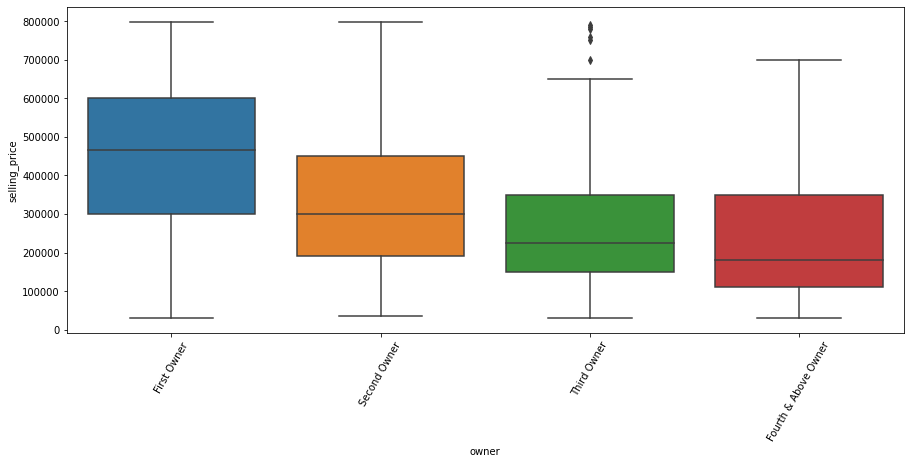

In [16]:
# Чем меньше владельцев было у машины, тем она дороже
box_plot(df, 'owner', 'selling_price', legend = False)

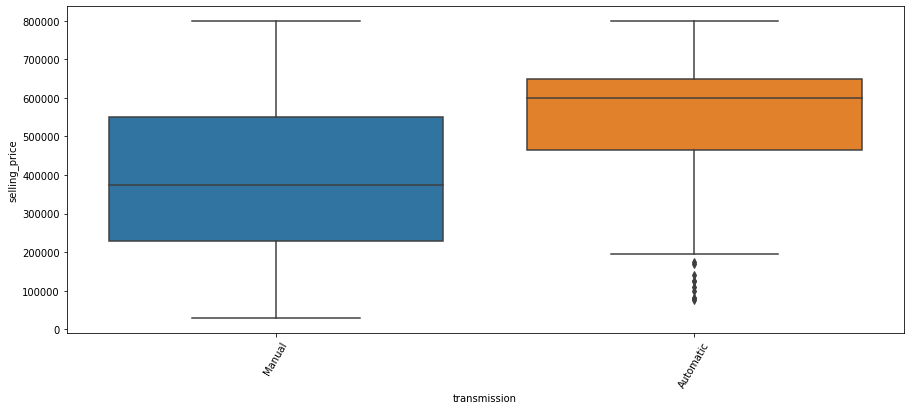

In [17]:
# Автомобили с автоматической коробкой передач дороже, чем с механийкой 
box_plot(df, 'transmission', 'selling_price', legend = False)

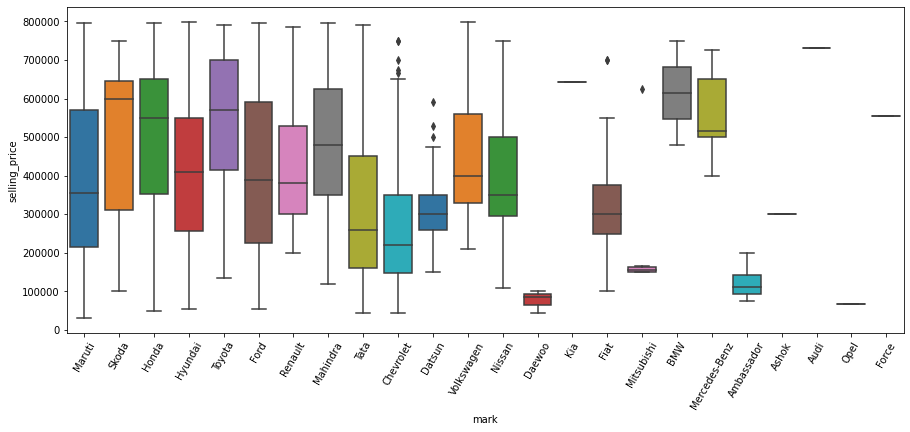

In [18]:
# Цена зависит от "уровня довереия" продавцу
box_plot(df, 'mark', 'selling_price', legend = False)

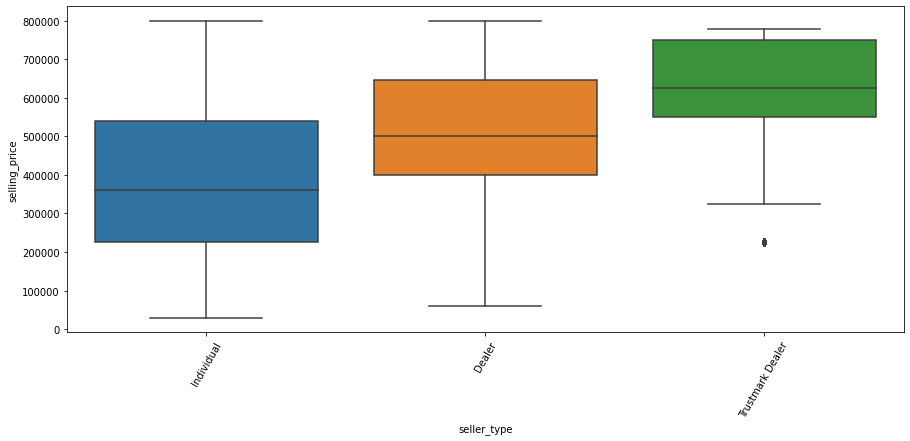

In [19]:
# Видно как цена зависит от марки автомобиля
box_plot(df, 'seller_type', 'selling_price', legend = False)

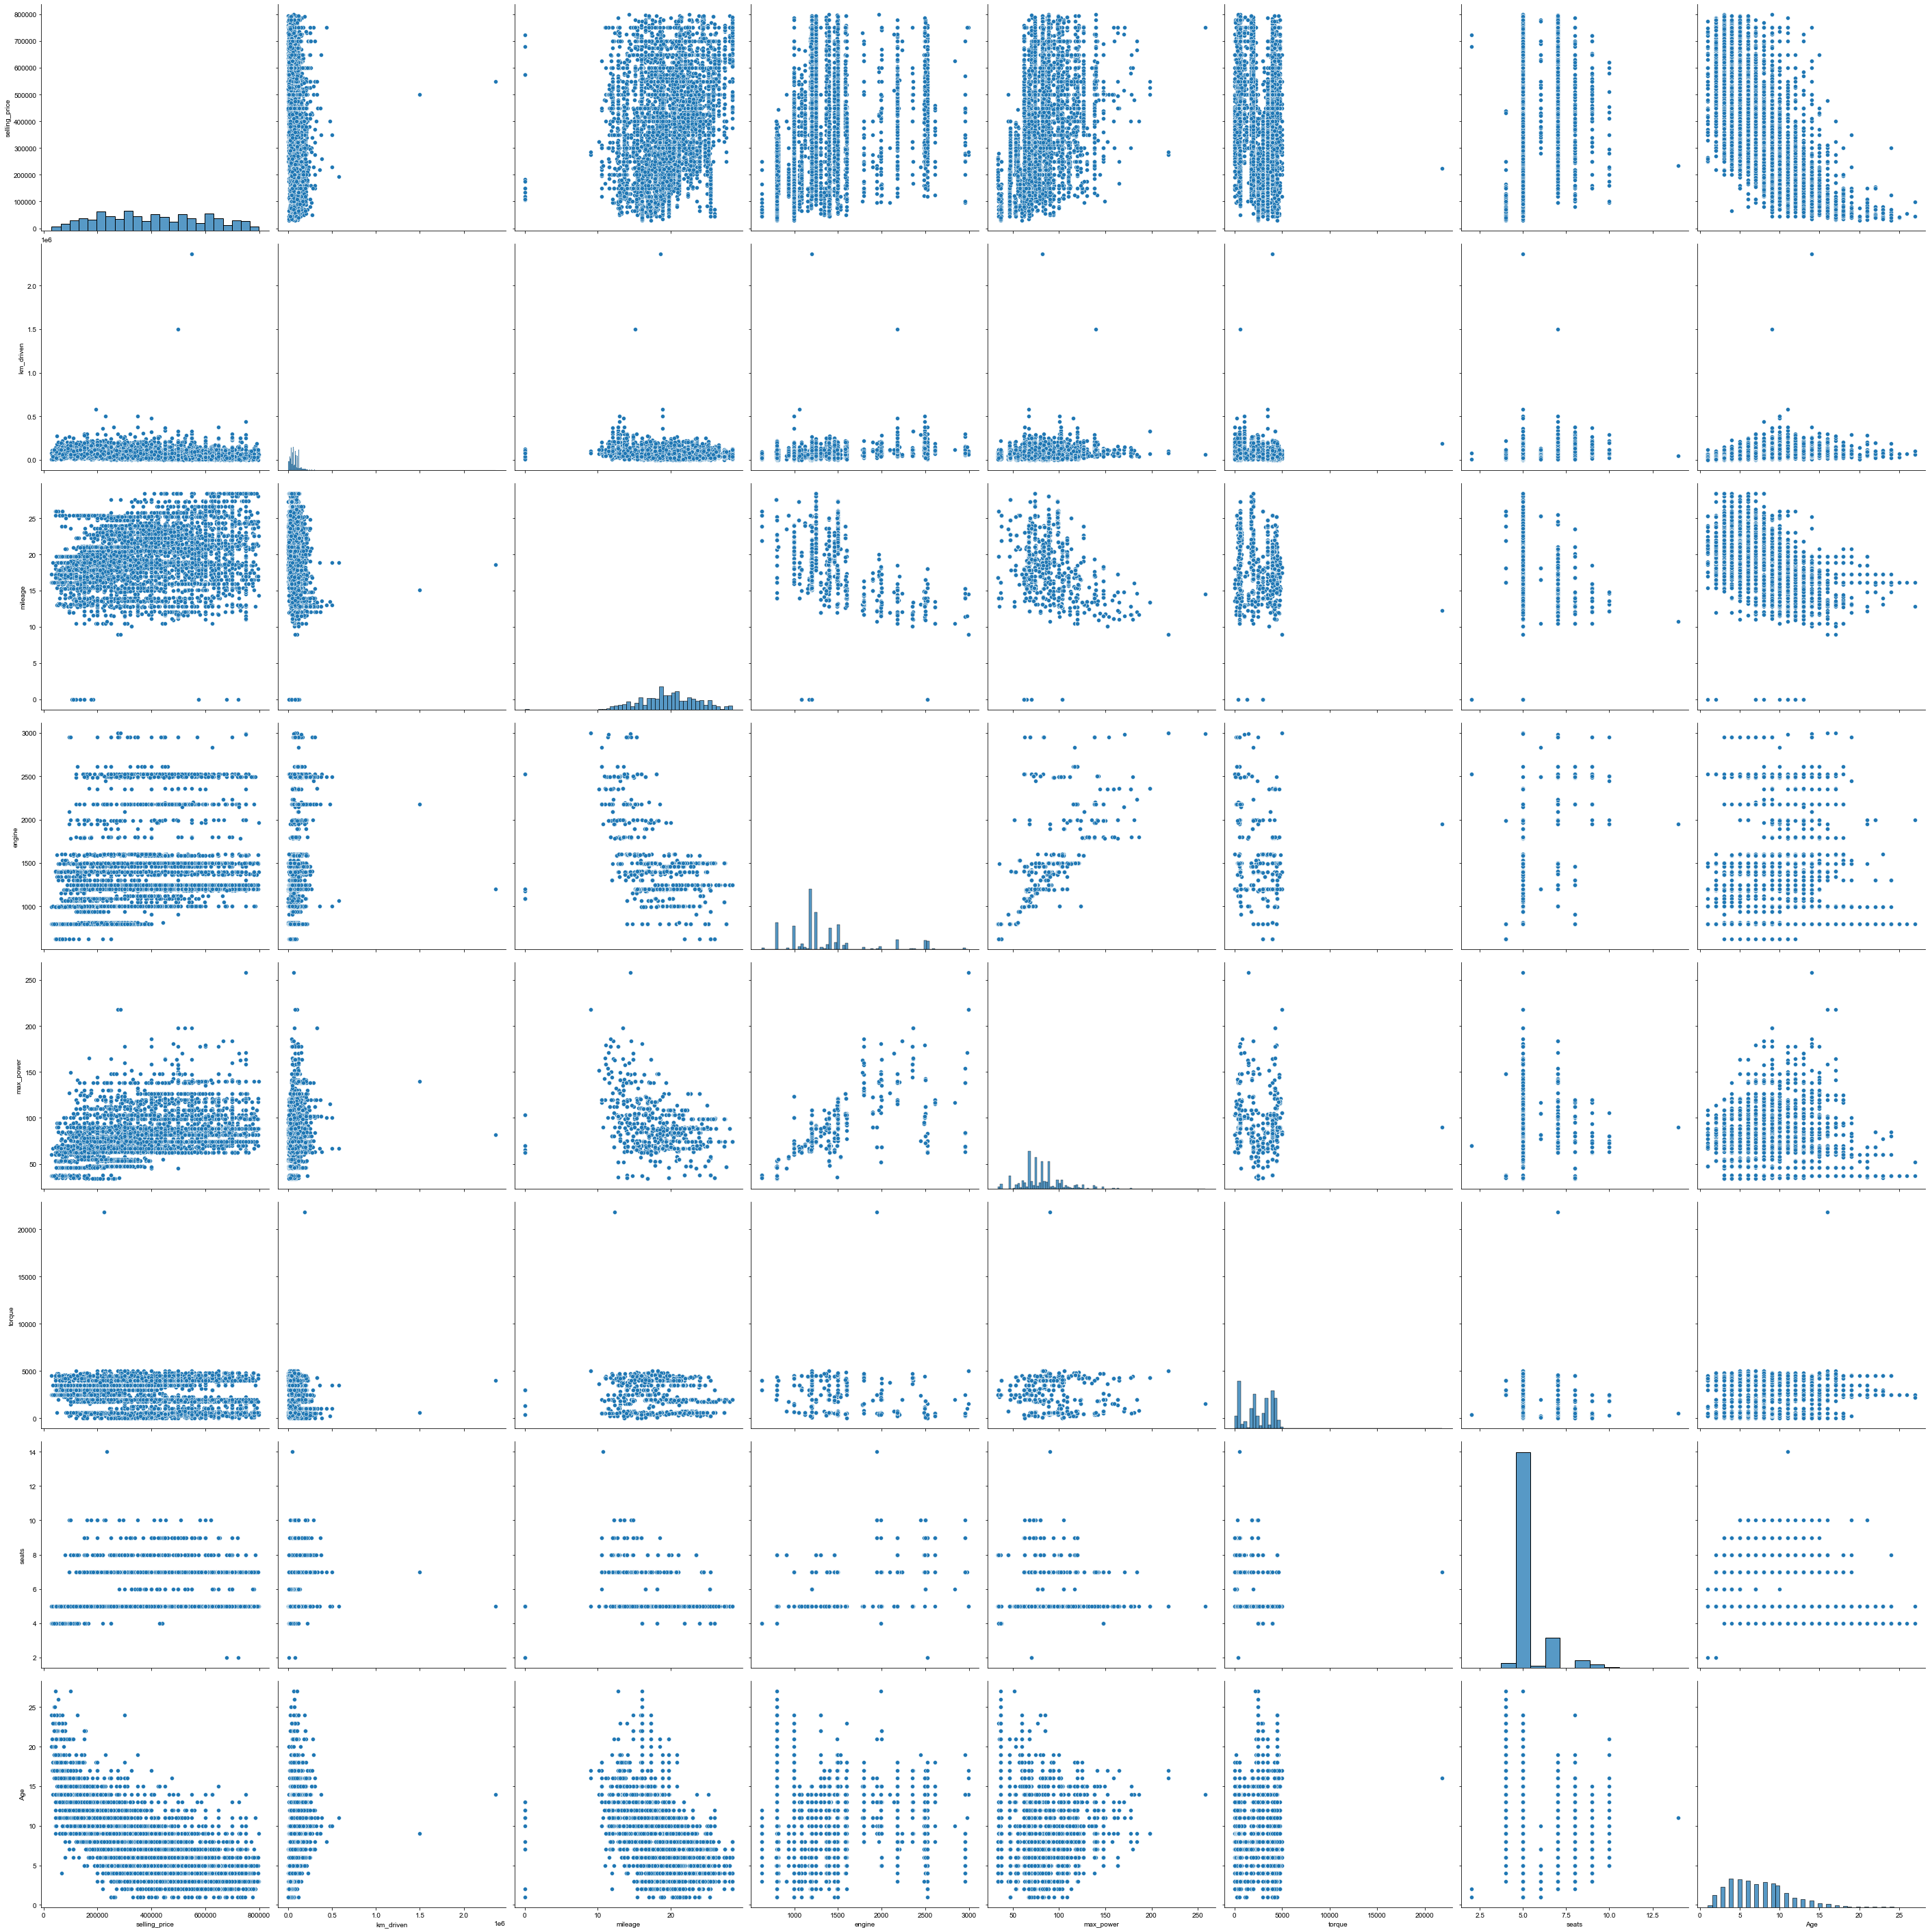

In [20]:
sns.pairplot(data = df[numerical_columns],
                            height = 5)
sns.set(font_scale=1.5)

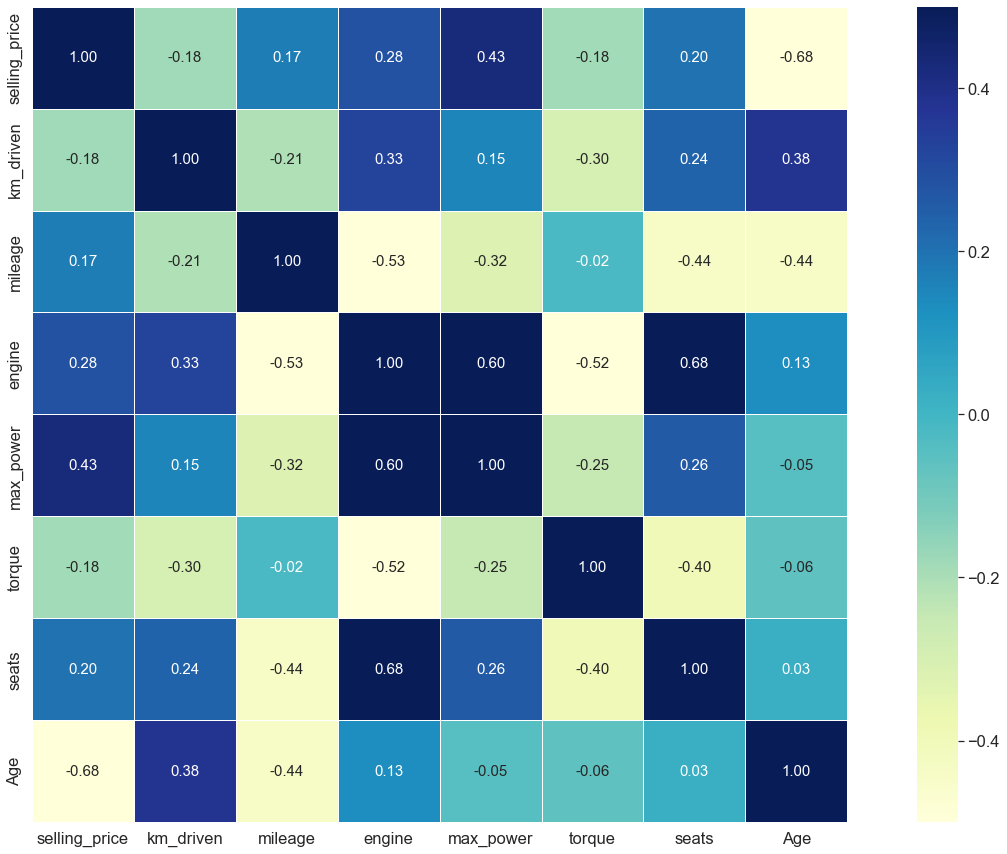

In [21]:
cm = np.corrcoef(df[numerical_columns].values.T)

sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(25,15))   
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 vmax=0.5,
                 vmin=-0.5,
                 cmap="YlGnBu",
                 linewidths = 0.5,
                 annot_kws={'size': 15},
                 yticklabels=numerical_columns,
                 xticklabels=numerical_columns)

# plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

# Кодирование категориальных переменных

In [22]:
# Обратим внимание на пробег машин, которые обозначены, как 'Test Drive Car'
# Для всех таких автомобилей пробем меньше чем квантилль 25 % (35000), поэтому
# Столбец 'owner' можно применить label encoder, где 'Test Drive Car' = 0 итд

# Если сразу отбросить выбросы, не останется 'Test Drive Car'
df[df['owner'] == 'Test Drive Car']

# Кодируем столбуц owner
owner_type = np.unique(df['owner'])
level_map = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 0}
df['owner'] = df['owner'].map(level_map)

In [23]:
cat_cols = ['mark','fuel', 'transmission', 'seller_type']
df = pd.get_dummies(df, columns=cat_cols)

In [24]:
df.columns

Index(['name', 'selling_price', 'km_driven', 'owner', 'mileage', 'engine',
       'max_power', 'torque', 'seats', 'Age', 'mark_Ambassador', 'mark_Ashok',
       'mark_Audi', 'mark_BMW', 'mark_Chevrolet', 'mark_Daewoo', 'mark_Datsun',
       'mark_Fiat', 'mark_Force', 'mark_Ford', 'mark_Honda', 'mark_Hyundai',
       'mark_Kia', 'mark_Mahindra', 'mark_Maruti', 'mark_Mercedes-Benz',
       'mark_Mitsubishi', 'mark_Nissan', 'mark_Opel', 'mark_Renault',
       'mark_Skoda', 'mark_Tata', 'mark_Toyota', 'mark_Volkswagen',
       'fuel_Diesel', 'fuel_Petrol', 'transmission_Automatic',
       'transmission_Manual', 'seller_type_Dealer', 'seller_type_Individual',
       'seller_type_Trustmark Dealer'],
      dtype='object')

In [25]:
X = df.drop(['selling_price'],axis=1).values
y = df['selling_price'].values


# Разбиваем выбоорку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 0)

# Сохраним полные названия автомобилей, для дальнейшего анализа

train_names = X_train[:, 0]
test_names = X_test[:, 0]

X_train = X_train[:, 1:]
X_test = X_test[:, 1:]


# Стандартизация

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Обучение моделей

## XGBoost

In [40]:
# Import xgboost ensemble model
import xgboost
from sklearn.model_selection import GridSearchCV

regressor=xgboost.XGBRegressor()

In [41]:
%%time
regressor.fit(X_train,y_train)

Wall time: 2.56 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

predictions=regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print('Mean squared error from neural network: ', mse)
print('Mean absolute error from neural network: ', mae)
print('R2 score from neural network: ', r2)

Mean squared error from neural network:  4912932829.745677
Mean absolute error from neural network:  47589.681041422715
R2 score from neural network:  0.8750656908470532


In [44]:
#Hyperparamter_Tuning
n_estimators = [50, 100, 500]
max_depth = [5, 10, 15]
booster=['gbtree']
learning_rate=[0.05,0.1,0.15]
min_child_weight=[2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
parameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [45]:
%%time
grid_cv = GridSearchCV(estimator=regressor,
            param_grid=parameter_grid,
            cv=5,
            scoring = 'neg_mean_absolute_error',n_jobs = 3,
            verbose = 5, 
            return_train_score = True)


grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Wall time: 27min 54s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100...
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
           

In [46]:
random_cv.best_params_

{'base_score': 1,
 'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 2,
 'n_estimators': 500}

In [49]:
regressor=xgboost.XGBRegressor(base_score = 1,
                               booster = 'gbtree',
                               learning_rate = 0.1,
                               max_depth = 5,
                               min_child_weight = 2,
                               n_estimators = 500)

regressor.fit(X_train,y_train)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
predictions=regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print('Mean squared error from neural network: ', mse)
print('Mean absolute error from neural network: ', mae)
print('R2 score from neural network: ', r2)

Mean squared error from neural network:  4067324565.909749
Mean absolute error from neural network:  45639.126302083336
R2 score from neural network:  0.8965692383038242


In [53]:
#Linear regression
from sklearn import linear_model


### Linear regression
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)
print('R2 score from linear regression: ', r2)

Mean squared error from linear regression:  10667553360.73213
Mean absolute error from linear regression:  75638.49391532989
R2 score from linear regression:  0.7287275328890961


In [54]:
from sklearn.tree import DecisionTreeRegressor
### Decision tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)

print('Mean squared error using decision tree: ', mse_dt)
print('Mean absolute error using decision tree: ', mae_dt)
print('R2 score from decision tree: ', r2)

Mean squared error using decision tree:  6520215568.369222
Mean absolute error using decision tree:  53334.80965391621
R2 score from decision tree:  0.8341930053204767


In [55]:
#Random forest.

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 30, random_state=30)
model.fit(X_train, y_train)

y_pred_RF = model.predict(X_test)

mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
r2 = r2_score(y_test, y_pred_RF)

print('Mean squared error using Random Forest: ', mse_RF)
print('Mean absolute error Using Random Forest: ', mae_RF)
print('R2 score from Random Forest: ', r2)

Mean squared error using Random Forest:  4059019012.25021
Mean absolute error Using Random Forest:  45295.56366855424
R2 score from Random Forest:  0.8967804458746472


In [ ]:
“squared_error”, “absolute_error”, “poisson”

In [58]:
#Hyperparamter_Tuning
n_estimators = [50, 100, 500]
max_depth = [5, 10, 30]
criterion=['squared_error']

# Define the grid of hyperparameters to search
parameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'criterion':criterion
    }

In [59]:
%%time
rf = RandomForestRegressor()

grid_cv = GridSearchCV(estimator=rf,
            param_grid=parameter_grid,
            cv=5,
            scoring = 'neg_mean_absolute_error',n_jobs = 3,
            verbose = 5, 
            return_train_score = True)


grid_cv.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 49.9 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=3,
             param_grid={'criterion': ['squared_error'],
                         'max_depth': [5, 10, 30],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=5)

In [60]:
grid_cv.best_params_

{'criterion': 'squared_error', 'max_depth': 30, 'n_estimators': 500}

In [61]:
model = RandomForestRegressor(criterion = 'squared_error',
                              max_depth = 30,
                              n_estimators = 500,
                              random_state=30)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=30)

In [62]:
y_pred_RF = model.predict(X_test)

mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
r2 = r2_score(y_test, y_pred_RF)

print('Mean squared error using Random Forest: ', mse_RF)
print('Mean absolute error Using Random Forest: ', mae_RF)
print('R2 score from Random Forest: ', r2)

Mean squared error using Random Forest:  3974533686.843105
Mean absolute error Using Random Forest:  45018.02104456946
R2 score from Random Forest:  0.8989288806546613
